<a href="https://colab.research.google.com/github/siddheshsathe/google-colab-repos/blob/master/GAN_with_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using MNIST data for learning working of GANs

Below are the steps that we'll be following
<br>
* Load data using `keras`'s built in `load_data`
* For demo/learning purpose we'll just use any one data class (anyone from 0 through 9), let's use 1
* Create `generator` model 
> * This model will have any latent (primary input noise) shape 
> * Eventually we'll make this with reshaping and/or upsampling the 2D images to the desired output image shape
> * While building this model, we'll not compile this as it will be compiled directly in the complete GAN model
* Create `discriminator` model
> * This model will just be a `binary classification` model which will output that the input to this model is a real or a fake image
> * Thus the output layer will consist of a `Dense` layer with single neuron.
> * Input shape of this model is of input image shape
> * Compile the model with `binary_crossentropy` and any suitable optimizer
* The training phase of this GAN model is not just usual with `fit` method
* We'll need to train the `discriminator` with below labels
> * `fake = 0`
> * `real = 1`


#1. Loading Data

In [1]:
%tensorflow_version 2.x
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

import numpy as np
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

TensorFlow 2.x selected.
11493376/11490434 [==============================] - 0s 0us/step


#2. Defining the models

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, UpSampling2D, Flatten, LeakyReLU, BatchNormalization, Reshape, Dropout
from tensorflow.keras.optimizers import SGD

In [0]:
coding_size = 100 # Initial latent size

In [0]:
generator = Sequential()

generator.add(Dense(7 * 7 * 256, activation='relu', input_shape=(100,)))
generator.add(Reshape((7, 7, 256)))

generator.add(Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
generator.add(Dropout(0.4))

generator.add(UpSampling2D())

generator.add(Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
generator.add(Dropout(0.4))

generator.add(UpSampling2D())

generator.add(BatchNormalization(momentum=0.15))

generator.add(Conv2D(1, kernel_size=5, strides=1, padding='same', activation='relu'))
generator.add(Dropout(0.4))

In [0]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3),
                        input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

In [0]:
GAN = Sequential([generator, discriminator])

In [0]:
discriminator.trainable = False

In [0]:
GAN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
GAN.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 28, 28, 1)         2292993   
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 212865    
Total params: 2,505,858
Trainable params: 2,292,865
Non-trainable params: 212,993
_________________________________________________________________


In [14]:
GAN.layers[0].summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         819328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 64)       

#3. Setting up training batches

In [0]:
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=coding_size)

In [0]:
batch_size = 32
dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)

#4. Training

In [17]:
i = 0
epochs = 20
for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    for x_data in dataset:
        # Generating the fake noise to feed in to generator
        noise = tf.random.normal([batch_size, coding_size])

        gen_images = generator(noise) # These will be fake images. Will be used to feed to the discriminator to show how fake images look

        # Creating labels for fake_and_real images
        y_fake_real = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

        # Creating x_data to be fed to discriminator. This has fake images and real images
        x_data_to_discriminator = tf.concat([gen_images, tf.dtypes.cast(x_data, tf.float32)], axis=0)

        # Discriminator training
        discriminator.trainable = True

        discriminator_loss = discriminator.train_on_batch(x_data_to_discriminator, y_fake_real)

        discriminator.trainable = False

        # Generator training
        y_label_generator = tf.constant([[1.0]] * batch_size)

        gan_loss = GAN.train_on_batch(noise, y_label_generator)

        if i % 200 == 0:
            print(f"Discriminator Loss: {discriminator_loss}")
            print(f"GAN Loss: {gan_loss}")
        i += 1

Epoch: 0
Discriminator Loss: [2.2922628, 0.546875]
GAN Loss: [0.4152518, 1.0]
Discriminator Loss: [1.9229115e-06, 1.0]
GAN Loss: [0.07765864, 0.96875]
Discriminator Loss: [0.0015598723, 1.0]
GAN Loss: [0.0009630422, 1.0]
Discriminator Loss: [0.21546817, 0.96875]
GAN Loss: [6.1404734e-15, 1.0]
Discriminator Loss: [0.008419101, 1.0]
GAN Loss: [1.6332394e-10, 1.0]
Discriminator Loss: [0.30253753, 0.984375]
GAN Loss: [2.110637e-27, 1.0]
Discriminator Loss: [1.20228115e-05, 1.0]
GAN Loss: [1.2170891e-35, 1.0]
Discriminator Loss: [1.2813614e-22, 1.0]
GAN Loss: [0.0, 1.0]
Discriminator Loss: [5.543957e-15, 1.0]
GAN Loss: [0.0, 1.0]
Discriminator Loss: [3.150439e-08, 1.0]
GAN Loss: [0.0, 1.0]
Epoch: 1
Discriminator Loss: [5.8090096e-22, 1.0]
GAN Loss: [0.0, 1.0]
Discriminator Loss: [7.110388e-07, 1.0]
GAN Loss: [4.2495025e-35, 1.0]
Discriminator Loss: [0.08969195, 0.984375]
GAN Loss: [2.6193784e-37, 1.0]
Discriminator Loss: [2.7543217e-30, 1.0]
GAN Loss: [0.0, 1.0]
Discriminator Loss: [0.0, 1.

# 5. Generating data with trained model

In [26]:
noise = tf.random.normal([1, coding_size])
noise.shape

TensorShape([1, 100])

In [0]:
generated_image = generator(noise)

In [20]:
generated_image.shape

TensorShape([1, 28, 28, 1])

In [0]:
import matplotlib.pyplot as plt

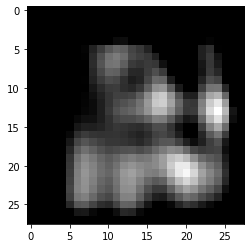

In [32]:
plt.imshow(generated_image[0].numpy().reshape(28, 28), cmap='gray')